
In this assignment I have run base code from Session 5, without L1/L2 with Batch Norm, with only L1 regularization and Batch Norm, with my L1 and L2 with Batch Norm. Plotted a single for test accuracy and test loss for each scenarios. Also displayed 25 misclassified images

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #dropout_prob=0.1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=3
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=5

        self.pool1= nn.MaxPool2d(2, 2) # Input=28, Output=14, rf=6

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=10
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=14
        )

        self.pool2= nn.MaxPool2d(2, 2) # Input=14, Output=7, rf=16

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(p=dropout_prob) # Input=7, Output=5, rf=24
        )


       
        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0, bias=False),
        ) # Input=5, Output=3, rf=32

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)  # Input=3, Output=1, rf=40
      
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
               
        x = self.global_avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
              ReLU-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:

#torch.manual_seed(11)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_param):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    regularization_loss = 0.0

    for param in model.parameters():
      if param.dim() > 1 :
          regularization_loss += param.norm(1)
    
    #l1_param = 0.0005
    regularization_loss *= l1_param
    loss += regularization_loss


    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)
PATH1 = './model_weights_without_l1_l2.pth'
EPOCHS = 25

test_losses_dict = {}
test_acc_dict = {}

i = 0
for param in [(0, 0, True, "Base Code" ), (0.0005, 0,True, "Only - L1" ), (0, 0.001,True, "Only - L2" ),(0.0005, 0.0001,True, " L1 & L2" )]:
    test_losses = []
    test_acc = []
    print(" Working for l1: " + str(param[0]) + " l2: " + str(param[1]) + " Batch Norm: " + str(param[2]))
    model.load_state_dict(torch.load(PATH))
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay= param[1])
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, param[0])
        test(model, device, test_loader, test_losses, test_acc)
        scheduler.step()
    test_losses_dict[param[3]] = test_losses 
    test_acc_dict[param[3]] = test_acc
    if i ==0:
        torch.save(model.state_dict(), PATH1)
    i += 1

  0%|          | 0/469 [00:00<?, ?it/s]

 Working for l1: 0 l2: 0 Batch Norm: True
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.03532125800848007 Batch_id=468 Accuracy=93.97: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.017295489087700844 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.030240213498473167 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.020771145820617676 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.07509095221757889 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.11538510769605637 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.07997364550828934 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.009773890487849712 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.0037215452175587416 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.01114027202129364 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.009132400155067444 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.011308029294013977 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.0029386281967163086 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.0066854506731033325 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.022713497281074524 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.006261865142732859 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.016679806634783745 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.023530378937721252 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.01288682222366333 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.019437352195382118 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.01514528226107359 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.0030014615040272474 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:24<00:00, 19.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.0017658720025792718 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.008876025676727295 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.05795648321509361 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

 Working for l1: 0.0005 l2: 0 Batch Norm: True
EPOCH: 0


Loss=0.3006690740585327 Batch_id=468 Accuracy=93.99: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.2473534196615219 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.18614134192466736 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:24<00:00, 19.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.20100398361682892 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9792/10000 (97.92%)

EPOCH: 4


Loss=0.12800517678260803 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.12845638394355774 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.10317540168762207 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 19.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.12550649046897888 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

EPOCH: 8


Loss=0.10630916059017181 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9950/10000 (99.50%)

EPOCH: 9


Loss=0.16424468159675598 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.11224810779094696 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9949/10000 (99.49%)

EPOCH: 11


Loss=0.08849187940359116 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.08152502775192261 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.08728376775979996 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.10496212542057037 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9955/10000 (99.55%)

EPOCH: 15


Loss=0.08558477461338043 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9956/10000 (99.56%)

EPOCH: 16


Loss=0.11974813044071198 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9953/10000 (99.53%)

EPOCH: 17


Loss=0.08889777958393097 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9954/10000 (99.54%)

EPOCH: 18


Loss=0.09614094346761703 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9955/10000 (99.55%)

EPOCH: 19


Loss=0.09542274475097656 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9954/10000 (99.54%)

EPOCH: 20


Loss=0.0790957510471344 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9957/10000 (99.57%)

EPOCH: 21


Loss=0.11479156464338303 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9955/10000 (99.55%)

EPOCH: 22


Loss=0.07981699705123901 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9957/10000 (99.57%)

EPOCH: 23


Loss=0.08435720950365067 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9954/10000 (99.54%)

EPOCH: 24


Loss=0.07961704581975937 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:24<00:00, 19.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9954/10000 (99.54%)

 Working for l1: 0 l2: 0.001 Batch Norm: True
EPOCH: 0


Loss=0.07435601204633713 Batch_id=468 Accuracy=93.86: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.1037723645567894 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.01695653796195984 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.010686869733035564 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


Loss=0.026896795257925987 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.07760677486658096 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.004301717039197683 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9948/10000 (99.48%)

EPOCH: 7


Loss=0.03455869480967522 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


Loss=0.01891079545021057 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9952/10000 (99.52%)

EPOCH: 9


Loss=0.022442316636443138 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9949/10000 (99.49%)

EPOCH: 10


Loss=0.006709659937769175 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9950/10000 (99.50%)

EPOCH: 11


Loss=0.046936098486185074 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.019029557704925537 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.016576306894421577 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:25<00:00, 18.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.06201845407485962 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.007761329412460327 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 16


Loss=0.012389272451400757 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.014128652401268482 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9950/10000 (99.50%)

EPOCH: 18


Loss=0.010829627513885498 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 19


Loss=0.03944583237171173 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


Loss=0.00680948281660676 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.03499659523367882 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9950/10000 (99.50%)

EPOCH: 22


Loss=0.011582453735172749 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9952/10000 (99.52%)

EPOCH: 23


Loss=0.00279737520031631 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.03425634279847145 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9954/10000 (99.54%)

 Working for l1: 0.0005 l2: 0.0001 Batch Norm: True
EPOCH: 0


Loss=0.347067266702652 Batch_id=468 Accuracy=93.94: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9765/10000 (97.65%)

EPOCH: 1


Loss=0.20612192153930664 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.14355549216270447 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.16823799908161163 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9749/10000 (97.49%)

EPOCH: 4


Loss=0.14241907000541687 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.21328473091125488 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9778/10000 (97.78%)

EPOCH: 6


Loss=0.23511695861816406 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.12889815866947174 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.10763964802026749 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.08689337223768234 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.1796480417251587 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0924992486834526 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.08072366565465927 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.07630790024995804 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.07681286334991455 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.12664657831192017 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9950/10000 (99.50%)

EPOCH: 16


Loss=0.07556990534067154 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9951/10000 (99.51%)

EPOCH: 17


Loss=0.08094368129968643 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9950/10000 (99.50%)

EPOCH: 18


Loss=0.08643843233585358 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

EPOCH: 19


Loss=0.09140004962682724 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


Loss=0.08660727739334106 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9951/10000 (99.51%)

EPOCH: 21


Loss=0.09831476211547852 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9952/10000 (99.52%)

EPOCH: 22


Loss=0.10284809023141861 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9952/10000 (99.52%)

EPOCH: 23


Loss=0.07726830244064331 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9951/10000 (99.51%)

EPOCH: 24


Loss=0.09211810678243637 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)



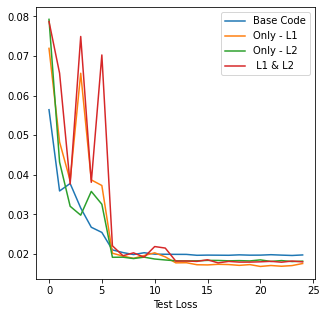

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize = (5,5))
for key, value in test_losses_dict.items():
    axes.plot(value, label=key)
    axes.legend()
plt.xlabel("Epoch")
plt.xlabel("Test Loss")
plt.show()


Text(0.5, 0, 'Test Accuracy')

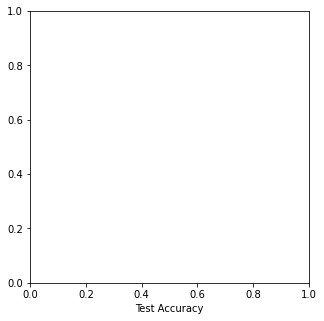

In [8]:
fig, axs = plt.subplots(figsize = (5,5))
for key, value in test_acc_dict.items():
    axes.plot(value, label=key)
    axes.legend()
plt.xlabel("Epoch")
plt.xlabel("Test Accuracy")


In [9]:
model.load_state_dict(torch.load(PATH1))

<All keys matched successfully>

In [10]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
for (i, [data, target]) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (pred !=  target).view(-1)
    img_nm = data[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
        correct_label_list.extend(target[idxs_mask].cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


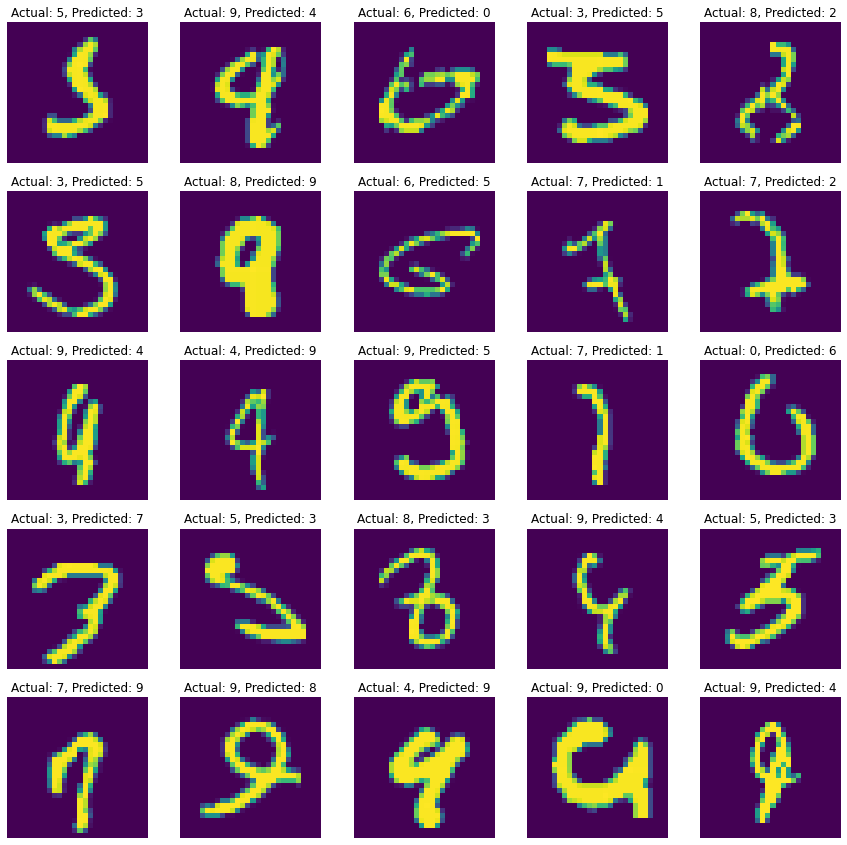

In [11]:
plt.figure(figsize=(15,15))
columns = 5
i= 0
# Display the list of 25 misclassified images
for index, image in enumerate(incorrect_image_list) :
    ax = plt.subplot(5, 5, i+1)
    ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
    ax.axis('off')
    plt.imshow(image)
    i +=1
    if i==25:
        break